# Creating the initial conditions

In [1]:
from roms_tools import Grid, InitialConditions

We start by creating a grid. Note that it is important to use the same grid throughout all the steps (i.e., creating tidal forcing, atmospheric forcing, initial conditions, etc.) to set up a consistent ROMS simulation. Here, we use the following grid with the default parameters for the vertical coordinate system.

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-21, center_lat=61, rot=20
)

Next, we specify the time that we want to make the initial conditions for.

In [3]:
from datetime import datetime

In [4]:
ini_time = datetime(2012, 1, 2)

## Physical initial conditions from GLORYS
In this section, we use GLORYS data to create our physical initial conditions, i.e., temperature, salinity, sea surface height, and velocities. (We will learn how to add biogeochemical initial conditions further down in the notebook.) The user is expected to have downloaded the GLORYS data spanning the desired ROMS domain and containing the desired `ini_time`. You can download the GLORYS data from https://www.mercator-ocean.eu/en/ocean-science/glorys/. Our downloaded data sits at the following location.

In [5]:
path = "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc"

Note that it would also be okay to provide a filename that contains data for more than just the day of interest. `ROMS-Tools` will pick out the correct day (and complain if the day of interest is not in the provided filename.) Or we can even use wildcards, such as `filename='/glade/derecho/scratch/bachman/GLORYS/NA/2012/*.nc'`. Note, however, that `ROMS-Tools` will operate more efficiently when the filename is as specific as possible.

We can now create the `InitialConditions` object.

In [6]:
%%time
initial_conditions = InitialConditions(
    grid=grid,
    ini_time=ini_time,
    source={"name": "GLORYS", "path": path},
    model_reference_date=datetime(
        2000, 1, 1
    ),  # model reference date. Default is January 1, 2000,
    use_dask=True,  # default is False
)

Selected time entry closest to the specified start_time (2012-01-02 00:00:00) within the range [2012-01-02 00:00:00, 2012-01-03 00:00:00]: ['2012-01-02T12:00:00.000000000']
CPU times: user 1min 3s, sys: 437 ms, total: 1min 4s
Wall time: 5.92 s


The initial conditions variables are held in an `xarray.Dataset` that is accessible via the `.ds` property.

In [7]:
initial_conditions.ds

<xarray.Dataset> Size: 21MB
Dimensions:     (ocean_time: 1, eta_rho: 102, xi_rho: 102, s_rho: 100,
                 xi_u: 101, eta_v: 101, s_w: 101)
Coordinates:
    abs_time    (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time  (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: eta_rho, xi_rho, s_rho, xi_u, eta_v, s_w
Data variables:
    zeta        (ocean_time, eta_rho, xi_rho) float32 42kB -0.4969 ... -0.9301
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 4MB dask.array<chunksize=(1, 100, 102, 101), meta=np.ndarray>
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 101, 102), meta=np.ndarray>
    ubar        (ocean_time, eta_rho, xi_u) float32 41kB dask.array<chunksize=(1, 102, 101), meta=np.ndarray>
    vbar        (ocean_time, eta_v, xi_rho) float32 41kB dask.array<chunksize=(1, 101, 102), meta=np.ndarray>
    w           (ocean_time, s_w, eta_rho, xi_rho) float32 4MB 0.0 0.0 ... 0.0
    Cs_r        (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    Cs_w        (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:                 ROMS initial conditions file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    ini_time:              2012-01-02 00:00:00
    model_reference_date:  2000-01-01 00:00:00
    source:                GLORYS
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

You can see that all initial conditions variables are Dask arrays, so these fields have not been actually computed yet. An exception is the variable `zeta`, which has been computed to check for NaNs in the interpolated fields, and the variable `w`, which is set to zero. Full computation will not be triggered until the `.plot` or `.save` methods are called.

## Plotting

Let's make some plots! As an example, let's have a look at the temperature field `temp`. It is three-dimensional with horizontal dimensions `eta_rho` and `xi_rho`, and vertical dimension `s_rho`.

In [8]:
initial_conditions.ds.temp

<xarray.DataArray 'temp' (ocean_time: 1, s_rho: 100, eta_rho: 102, xi_rho: 102)> Size: 4MB
dask.array<where, shape=(1, 100, 102, 102), dtype=float32, chunksize=(1, 100, 102, 102), chunktype=numpy.ndarray>
Coordinates:
    abs_time    (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time  (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: s_rho, eta_rho, xi_rho
Attributes:
    long_name:  potential temperature
    units:      degrees Celsius

We first want to plot different layers of the temperature field, i.e., slice along the vertical dimension `s`.

In [9]:
from dask.diagnostics import ProgressBar

[########################################] | 100% Completed | 2.22 sms
CPU times: user 3min 21s, sys: 326 ms, total: 3min 21s
Wall time: 2.9 s


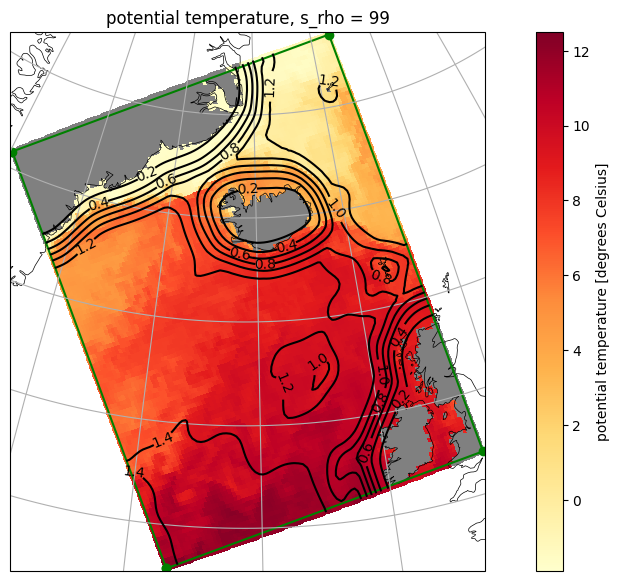

In [10]:
with ProgressBar():
    %time initial_conditions.plot("temp", s=-1, depth_contours=True)  # plot uppermost layer

Note that this took some time because the computation of the three-dimensional temperature field was triggered before plotting. Indeed, the temperature values are now fully computed (and don't need to be re-computed when calling the `.plot` or `.save` methods).

In [11]:
initial_conditions.ds.temp

<xarray.DataArray 'temp' (ocean_time: 1, s_rho: 100, eta_rho: 102, xi_rho: 102)> Size: 4MB
array([[[[ 3.2133336 ,  2.8887794 ,  2.8351593 , ...,  7.874808  ,
           7.875535  ,  7.958319  ],
         [ 2.927417  ,  2.8645372 ,  2.9462984 , ...,  7.9686456 ,
           7.9079647 ,  7.9008074 ],
         [ 3.0651119 ,  3.058829  ,  2.8778355 , ...,  8.003046  ,
           7.909738  ,  7.8565807 ],
         ...,
         [ 5.406361  ,  5.1410503 ,  4.8993187 , ..., -0.9849356 ,
          -0.99234957, -0.9892463 ],
         [ 5.881658  ,  5.5948286 ,  5.330797  , ..., -0.9963152 ,
          -1.0010488 , -1.0041753 ],
         [ 6.3468337 ,  6.0467267 ,  5.765318  , ..., -1.006307  ,
          -1.0111945 , -1.0104384 ]],

        [[ 3.2133336 ,  2.9167864 ,  2.8394558 , ...,  7.874781  ,
           7.87551   ,  7.958297  ],
         [ 2.939567  ,  2.884021  ,  2.9462984 , ...,  7.968622  ,
           7.9079413 ,  7.9007845 ],
         [ 3.0651119 ,  3.058829  ,  2.8778355 , ...,  8.003025  ,
           7.909716  ,  7.8565583 ],
...
         [ 5.4032855 ,  5.1379814 ,  4.8962464 , ..., -0.8384761 ,
          -0.5910594 , -0.43460342],
         [ 5.878533  ,  5.591718  ,  5.3276925 , ..., -0.5207716 ,
          -0.5480129 , -0.68099326],
         [ 6.343665  ,  6.043577  ,  5.7621803 , ..., -0.6358841 ,
          -0.6390127 , -0.6442147 ]],

        [[11.861317  , 11.975734  , 12.094538  , ...,  7.8723536 ,
           7.87313   ,  7.956066  ],
         [12.045038  , 12.128336  , 12.21467   , ...,  7.966468  ,
           7.9057093 ,  7.8985724 ],
         [12.213307  , 12.043888  , 11.924701  , ...,  8.001027  ,
           7.907577  ,  7.8543725 ],
         ...,
         [ 5.4032855 ,  5.1379814 ,  4.8962464 , ..., -0.8383553 ,
          -0.5910602 , -0.43436944],
         [ 5.878533  ,  5.591718  ,  5.3276925 , ..., -0.5212487 ,
          -0.54781103, -0.6808458 ],
         [ 6.343665  ,  6.043577  ,  5.7621803 , ..., -0.6358841 ,
          -0.6392241 , -0.6443343 ]]]], dtype=float32)
Coordinates:
    abs_time    (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time  (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: s_rho, eta_rho, xi_rho
Attributes:
    long_name:  potential temperature
    units:      degrees Celsius

Now plotting of the temperature field should be a lot faster.

CPU times: user 139 ms, sys: 3.98 ms, total: 143 ms
Wall time: 177 ms


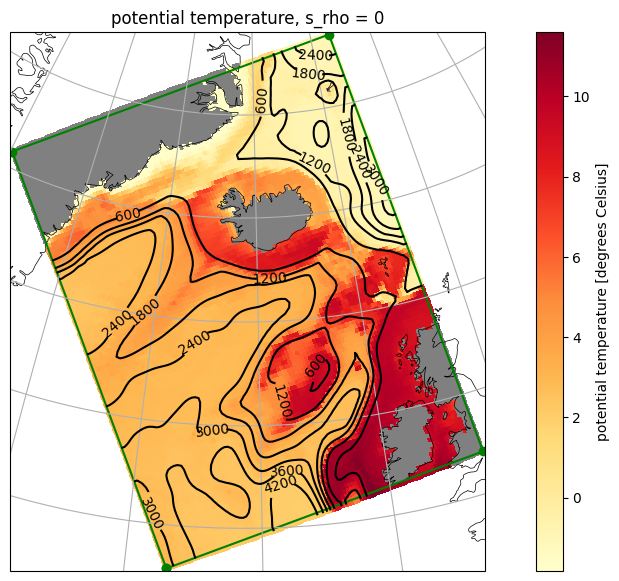

In [12]:
%time initial_conditions.plot("temp", s=0, depth_contours=True)  # plot bottom layer

Next, we slice our domain along one of the horizontal dimensions and look at temperature along these sections.

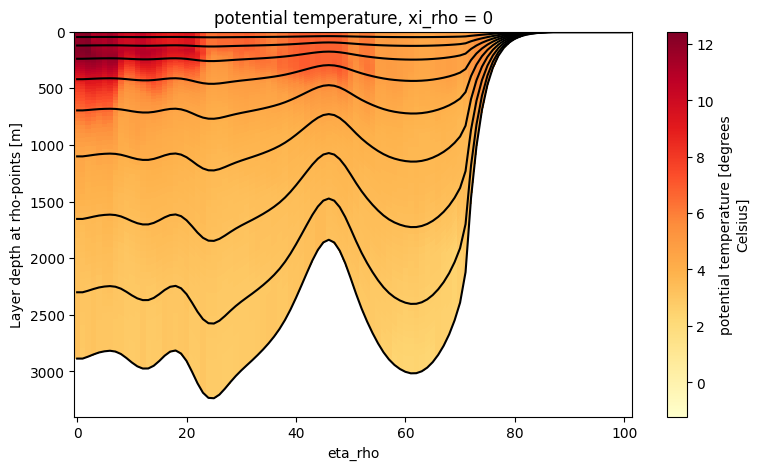

In [13]:
initial_conditions.plot("temp", xi=0, layer_contours=True)

Note that even though we have a total of 100 layers, `layer_contours = True` will create a plot with a maximum of 10 contours to ensure plot clarity.

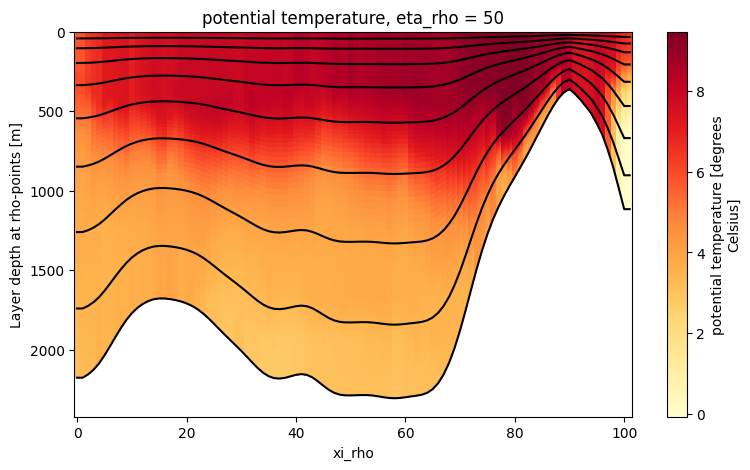

In [14]:
initial_conditions.plot("temp", eta=50, layer_contours=True)

We can also plot a depth profile at at certain spatial location.

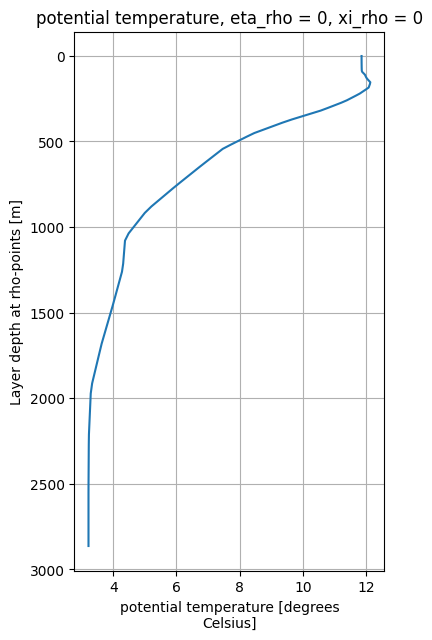

In [15]:
initial_conditions.plot("temp", eta=0, xi=0)

Finally, we can look at a transect in a certain layer and at a fixed `eta_rho` (similarly `xi_rho`).

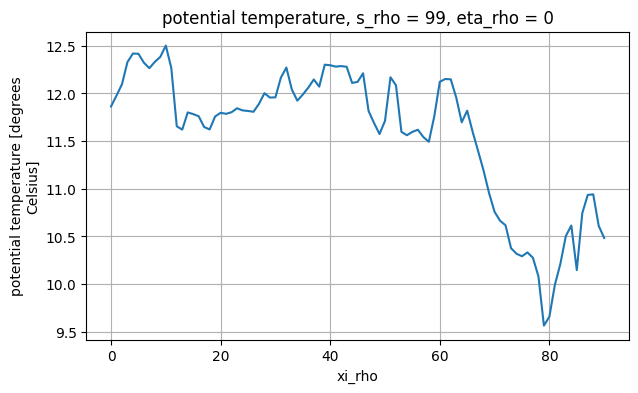

In [16]:
initial_conditions.plot("temp", eta=0, s=-1)

## Adding BGC initial conditions

We now want to prepare a simulation in which we run ROMS with MARBL biogeochemistry (BGC), so we need to prepare both physical and BGC initial conditions.  We create physical and BGC initial conditions together because ROMS needs a single initial conditions file. We use  

* GLORYS data to create our physical initial conditions, i.e., temperature, salinity, sea surface height, and velocities
* a biogeochemical (BGC) CESM climatology to create our BGC initial conditions

The CESM climatology is located here.

In [17]:
bgc_path = "/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-climatology_lowres_regridded.nc"

The initial conditions are created as above, but now with additional information about the `bgc_source`.

In [18]:
%%time
initial_conditions_with_bgc = InitialConditions(
    grid=grid,
    ini_time=ini_time,
    source={"name": "GLORYS", "path": path},
    bgc_source={
        "name": "CESM_REGRIDDED",
        "path": bgc_path,
        "climatology": True,
    },  # bgc_source is optional
    use_dask=True,  # default is False
)

Selected time entry closest to the specified start_time (2012-01-02 00:00:00) within the range [2012-01-02 00:00:00, 2012-01-03 00:00:00]: ['2012-01-02T12:00:00.000000000']
CPU times: user 1min 21s, sys: 450 ms, total: 1min 21s
Wall time: 12.2 s


In [19]:
initial_conditions_with_bgc.ds

<xarray.Dataset> Size: 154MB
Dimensions:      (ocean_time: 1, eta_rho: 102, xi_rho: 102, s_rho: 100,
                  xi_u: 101, eta_v: 101, s_w: 101)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: eta_rho, xi_rho, s_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    zeta         (ocean_time, eta_rho, xi_rho) float32 42kB -0.4969 ... -0.9301
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 4MB dask.array<chunksize=(1, 100, 102, 101), meta=np.ndarray>
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 101, 102), meta=np.ndarray>
    ubar         (ocean_time, eta_rho, xi_u) float32 41kB dask.array<chunksize=(1, 102, 101), meta=np.ndarray>
    ...           ...
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    spCaCO3      (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    zooC         (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 4MB 0.0 0.0 ... 0.0
    Cs_r         (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    Cs_w         (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:                 ROMS initial conditions file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    ini_time:              2012-01-02 00:00:00
    model_reference_date:  2000-01-01 00:00:00
    source:                GLORYS
    bgc_source:            CESM_REGRIDDED
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

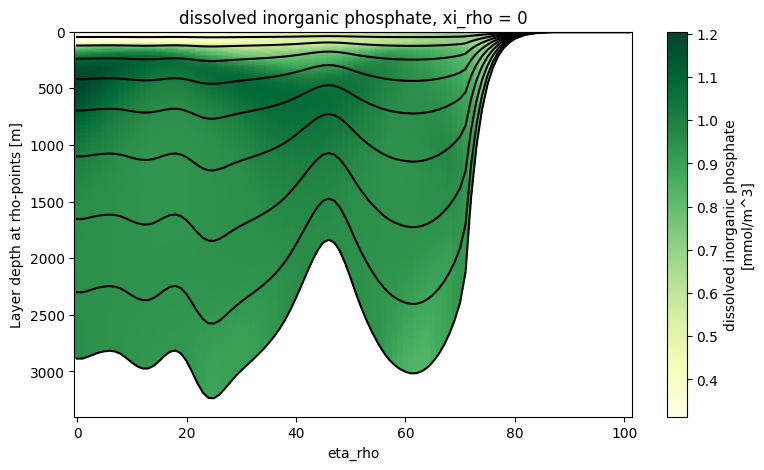

In [20]:
initial_conditions_with_bgc.plot("PO4", xi=0, layer_contours=True)

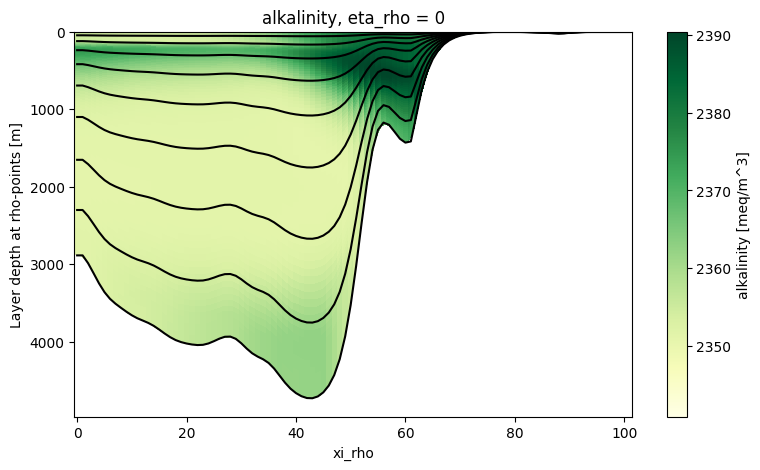

In [21]:
initial_conditions_with_bgc.plot("ALK", eta=0, layer_contours=True)

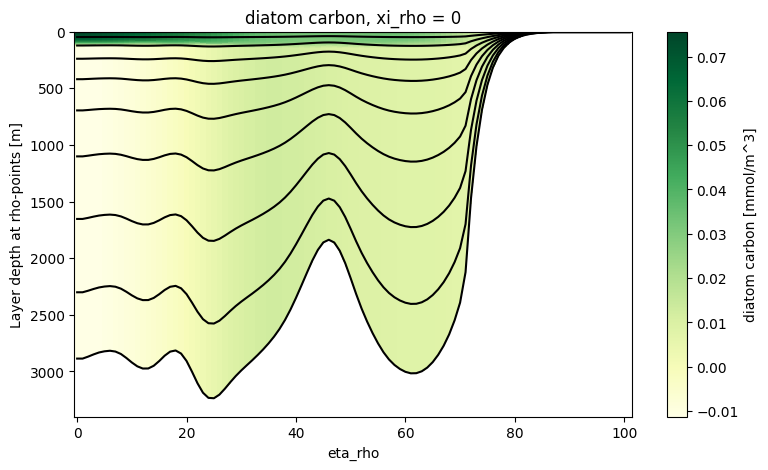

In [22]:
initial_conditions_with_bgc.plot("diatC", xi=0, layer_contours=True)

## Saving as NetCDF or YAML file

We can now save the dataset as a NetCDF file.

In [23]:
filepath = "/pscratch/sd/n/nloose/initial_conditions/my_initial_conditions.nc"

In [24]:
with ProgressBar():
    %time initial_conditions_with_bgc.save(filepath)

[########################################] | 100% Completed | 110.42 s
CPU times: user 3h 54min 23s, sys: 14.5 s, total: 3h 54min 38s
Wall time: 1min 51s


We can also export the parameters of our `InitialConditions` object to a YAML file.

In [25]:
yaml_filepath = "/pscratch/sd/n/nloose/initial_conditions/my_initial_conditions.yaml"

In [26]:
initial_conditions_with_bgc.to_yaml(yaml_filepath)

In [27]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev138+dirty
---
Grid:
  N: 100
  center_lat: 61
  center_lon: -21
  hc: 300.0
  hmin: 5.0
  nx: 100
  ny: 100
  rot: 20
  size_x: 1800
  size_y: 2400
  theta_b: 2.0
  theta_s: 5.0
  topography_source: ETOPO5
InitialConditions:
  bgc_source:
    climatology: true
    name: CESM_REGRIDDED
    path: /global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-climatology_lowres_regridded.nc
  ini_time: '2012-01-02T00:00:00'
  model_reference_date: '2000-01-01T00:00:00'
  source:
    climatology: false
    name: GLORYS
    path: /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc



## Creating initial conditions from an existing YAML file

In [28]:
%time the_same_initial_conditions_with_bgc = InitialConditions.from_yaml(yaml_filepath, use_dask=True)

Selected time entry closest to the specified start_time (2012-01-02 00:00:00) within the range [2012-01-02 00:00:00, 2012-01-03 00:00:00]: ['2012-01-02T12:00:00.000000000']
CPU times: user 1min 23s, sys: 568 ms, total: 1min 23s
Wall time: 14.3 s


In [29]:
the_same_initial_conditions_with_bgc.ds

<xarray.Dataset> Size: 154MB
Dimensions:      (ocean_time: 1, eta_rho: 102, xi_rho: 102, s_rho: 100,
                  xi_u: 101, eta_v: 101, s_w: 101)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: eta_rho, xi_rho, s_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    zeta         (ocean_time, eta_rho, xi_rho) float32 42kB -0.4969 ... -0.9301
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 4MB dask.array<chunksize=(1, 100, 102, 101), meta=np.ndarray>
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 101, 102), meta=np.ndarray>
    ubar         (ocean_time, eta_rho, xi_u) float32 41kB dask.array<chunksize=(1, 102, 101), meta=np.ndarray>
    ...           ...
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    spCaCO3      (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    zooC         (ocean_time, s_rho, eta_rho, xi_rho) float32 4MB dask.array<chunksize=(1, 100, 102, 102), meta=np.ndarray>
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 4MB 0.0 0.0 ... 0.0
    Cs_r         (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    Cs_w         (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:                 ROMS initial conditions file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    ini_time:              2012-01-02 00:00:00
    model_reference_date:  2000-01-01 00:00:00
    source:                GLORYS
    bgc_source:            CESM_REGRIDDED
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0